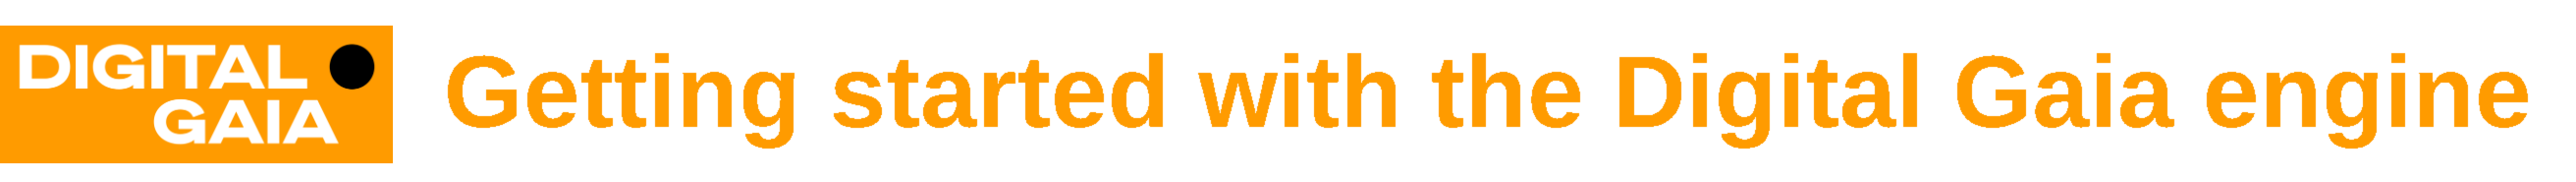

## <u>Table of contents:</u>

**1. General information**<br/>
&emsp;&emsp; 1.1. The ontology<br/>
&emsp;&emsp; 1.2. The project's configuration file<br/>
&emsp;&emsp; 1.3. The format of report files<br/><br/>
**2. The high level interface of the Digital Gaia engine**<br/>
&emsp;&emsp; 2.1. Import and setup of required packages <br/>
&emsp;&emsp; 2.2. Loading the data and creating agents <br/>
&emsp;&emsp; 2.3. Performing predictions and visualising the results <br/>
&emsp;&emsp; 2.4. Performing inference and visualising the results <br/><br/>
**3. Creating a custom agent**<br/>
&emsp;&emsp; 3.1. The generative model and variational distribution<br/>
&emsp;&emsp; 3.2. The agent interface<br/>
&emsp;&emsp; 3.3. The code of the custom agent<br/>
&emsp;&emsp; 3.4. Visualising the custom agent<br/>

## 1. General information

This notebook explains how to use the Digital Gaia engine. The engine's goal is to evaluate a project (e.g., an agricultural or reforestation project) based on different metrics such as: its impact on the environment, its expected yield, ...

Each project needs a configuration file, the convention is to use the following path format: 

```
    ./data/projects/<company_or_association_name>/<project_name>.json
```
For example, if the company is `Google` and their project is called `AmazonReforestation`, we get the following:
```
    ./data/projects/Google/AmazonReforestation.json
```

## 1.1. The ontology

The ontology is a structured representation of the concepts used by the models of the Digital Gaia engine. The ontology is structured as follows:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color=red>&lt;version&gt;</font>.<font color=darkorange>&lt;variable_type&gt;</font>.<font color=goldenrod>&lt;namespace&gt;</font>.<font color=green>&lt;domain&gt;</font>.<font color=blue>&lt;concept&gt;</font>.<font color=purple>&lt;variable&gt;</font>.<font color=hotpink>&lt;unit_or_category&gt;</font>

For example:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color=red>&lt;v0&gt;</font>.<font color=darkorange>&lt;Intervention&gt;</font>.<font color=goldenrod>&lt;Base&gt;</font>.<font color=green>&lt;Agriculture&gt;</font>.<font color=blue>&lt;Harvest&gt;</font>.<font color=purple>&lt;HarvestCrops&gt;</font>.<font color=hotpink>&lt;Categorical&gt;</font>

A table documenting the currently supported entries of the ontology is available [here](https://github.com/gaia-os/natural_models/blob/feature/adding-get-started/src/natural_models/ontology/documentation/ontology_doc.pdf).

### 1.1.1. Variable types

The first version of the ontology will includes the following variable types:
- <font color=darkorange>&lt;Intervention&gt;</font> (also known as actions, treatments or practices)
- <font color=darkorange>&lt;Shock&gt;</font> (notably the weather)
- <font color=darkorange>&lt;Vegetation&gt;</font> (for information conserning plant species and vegetation types, e.g., forest, grassland, ...)
- <font color=darkorange>&lt;Outcome&gt;</font> (colloquially sometimes called targets or state variables)
- <font color=darkorange>&lt;Measurement&gt;</font> (also known as observables or observations)
- <font color=darkorange>&lt;Parameter&gt;</font> (the parameter encoding real world properties, e.g., plant growth rates, ...)

However, the current version of the ontology is still an alpha that contains the following variable types: shock, intervention, vegetation, and measurement. While the parameter and outcome types will be added soon.

### 1.1.2. Namespaces

A namespaces provide a way to differentiate between two entries that would otherwise be the same. This is useful as different associations or companies may use the same name for slightly different practices. The namespace <font color=goldenrod>&lt;Base&gt;</font> is special as it represents Digital Gaia's namespace, and contains general concepts that are widely used throughout the network of famers and modelers.

### 1.1.3. Domains

A domain represents specified sphere of activity or knowledge, for example: <font color=green>&lt;Agroforestry&gt;</font>, <font color=green>&lt;Agriculture&gt;</font>, <font color=green>&lt;Forestry&gt;</font>, and <font color=green>&lt;Aquaculture&gt;</font>, are all domains. This level of the ontology allows the separation of concepts and variables across domains. For example, the number of plant species is enormous, but separating them into domains helps enumerating them in the ontology.

### 1.1.4. Concepts and Variables

A concept represent an abstract idea such as for example: <font color=blue>&lt;PlantDensity&gt;</font>, <font color=blue>&lt;Irrigation&gt;</font> or <font color=blue>&lt;Fertiliser&gt;</font>. Concepts are just above variables in the hierarchy, and the variables represent specific instances of these abstract concepts. For example, <font color=purple>&lt;HempDensity&gt;</font> and <font color=purple>&lt;AlfalfaDensity&gt;</font> could be instances of <font color=blue>&lt;PlantDensity&gt;</font>.

### 1.1.5. Units or categories

Finally, the lowest level in the ontology represents units or categories. Categories of <font color=purple>&lt;PlantSpecies&gt;</font> could be: <font color=hotpink>&lt;Hemp&gt;</font>,  <font color=hotpink>&lt;Copaiba&gt;</font> and <font color=hotpink>&lt;BrazilNut&gt;</font>, while a variable's unit could be: <font color=hotpink>&lt;Kg&gt;</font>, <font color=hotpink>&lt;Km&#xB2;&gt;</font> and <font color=hotpink>&lt;L&gt;</font>. However, the units are still work in progress, and for now, if a variable is not a category it can only be <font color=hotpink>&lt;Continuous&gt;</font>.

## 1.2. The project's configuration file

This section describes the format of a project's configuration files, e.g., `./data/projects/Tutorial/GetStarted.json`.

The configuration file defines the project's name, its starting date, and its duration in years as follows:

```json
{
	"name": "Tutorial.GetStarted",
	"start_date": "2021-12-01",
	"duration_in_years": 1,
    ...
}
```

The configuration file also defines the strategies available to the agents. Each strategy has a name, and requires the agent to support a set of interventions and plant species. Additionally, each strategy has its own objective that defines which variable(s) are relevant to the project's goal. Finally, each strategy defines the sequence of actions that the agent should perform when following this strategy. A simple strategy could be defined like that: 

```json
{
    ...
	"strategies": [{
        "name": "demo_policy",
        "species": [
            "v0.vegetation.base.agriculture.Plant.PlantSpecies.Hemp",
        ],
        "interventions": {
            "planting-hemp": "v0.intervention.base.agriculture.Planting.PlantingSeeds.HempSeeds",
            "harvest-hemp": "v0.intervention.base.agriculture.Harvest.HarvestCrops.Hemp",
        },
        "objective": {
            "target_variable": "v0.measurement.base.agriculture.Yield.HempYield.Continuous",
            "aggregator": "sum",
            "constraints": []
        },
        "policy": [
            [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],
            ["planting-hemp"], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ["harvest-hemp"],
            [], [], [], [], [], [], [], [], [], [], []
        ]
    }]
}
```

The last part of the configuration file defines the project's lots. A lot corresponds to an area on which a strategy is deployed. Each lot has a name, a boundary (also refered to as bounds), as well as an associated strategy. Additional, information about the lot can be stored in the `geo_params` field, e.g., the soil type, the climate zone, the average slope and average annual rainfall. A simple lot can be defined as follows:

```json
{
    ...
	"lots": [{
		"name": "lot_0",
        "bounds": {
            "type": "Polygon",
            "coordinates": [[
                [-89.56672668457031, 45.101638366018676],
                [-89.56672668457031, 45.09295909075445],
                [-89.55780029296875, 45.09295909075445],
                [-89.55780029296875, 45.101638366018676],
                [-89.56672668457031, 45.101638366018676]
            ]]
        },
        "strategy": "demo_policy",
        "geo_params": {
            "soil_type": {"type": "LV-stn.abm-ai.ct.lon.oh.sia", "taxonomy": "<url>"},
            "climate_zone": {"type": "Dfa", "taxonomy": "<url>"},
            "avg_slope": {"slope_pct": 0.05, "heading_deg": 180.0},
            "avg_annual_rainfall": {"mm_m2": 12345}
        }
	}],
    ...
}
```

## 1.3. The format of report files 

Reports are stored on the filesytem as JSON files. The name of each report file contains the date at which the report was received by Digital Giai, as well as a unique index that differentiate this report from other reports, e.g., `./data/reports/report-2021-12-15.2696cd6c-ab30-44af-ac80-de336152526a.json`. <br/>

Each report file contains information describing a set of observations made by one of Digital Gaia's partners. Moreover, each report file contains the location and date describing where and when the measurement was made, as well as the report's unique index. Finally, each report can contain additional information such as: 
- the name of the project for which the measurements were performed
- the email of the person who provided Digital Gaia with the report
- a URL describing the provenance of the data
- a set of URLs pointing to evidence supporting the observations contained in the report <br/>

An example of a simple report could look like this:

```json
{
  "id": "2696cd6c-ab30-44af-ac80-de336152526a",
  "datetime": "2021-12-15",
  "location": {
    "coordinates": [-89.56181335449219, 45.096866607666016],
    "type": "Point"
  },
  "project_name": "Tutorial.GetStarted",
  "reporter": "tuto@gmail.com",
  "provenance": "<url>",
  "observations": [{
      "name": "v0.measurement.base.agriculture.Yield.HempYield.Continuous",
      "value": [0.2]
    }
  ],
  "evidence": []
}
```

# 2. The high level interface of the Digital Gaia engine

## 2.1. Import and setup of required packages

**Importantly, if you modify the code on the filesystem, e.g., in the `fangorn` repository, you will need to restart the notebook for jupyter to take into account your changes.** Let's import the required packages:

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import required packages
from os.path import abspath, dirname
import sys
import matplotlib.pyplot as plt
import jax.numpy as jnp
from numpyro.optim import optax_to_numpyro
from numpyro.infer import Trace_ELBO
import optax
from numpyro import set_platform

# Retrieve the fangorn directory
import digital_gaia.fangorn as fangorn
fangorn_dir = dirname(dirname(dirname(abspath(fangorn.__file__))))

# Tell numpyro whether to use cpu or gpu
use_gpu = False
if use_gpu is True:
    set_platform('gpu')
else:
    set_platform('cpu')

# Import required classes from the natural_models package
from digital_gaia.fangorn.agents.AgentFactory import AgentFactory
from digital_gaia.fangorn.assessment.DataLoader import DataLoader
from digital_gaia.fangorn.kernels.impl.MCMCKernel import MCMCKernel
from digital_gaia.fangorn.kernels.impl.SVIKernel import SVIKernel
from digital_gaia.fangorn.visualisation.distributions import draw_beliefs
from digital_gaia.fangorn.visualisation.distributions import compare_posteriors

## 2.2. Loading the data and creating agents

### 2.2.1. Loading the data

The class responsible for loading the data from the filesystem is called: `DataLoader`.

It requires the path to the project's configuration file, and provide access to: lots information, available reports, policy to evaluate, etc...

In [2]:
# Load the data corresponding to the Roots & Culture model
data_loader = DataLoader(f"{fangorn_dir}/data/projects/Roots-and-Culture/roots-indoor1.json")

### 2.2.2. Creating compatible agents

The class responsible for instantiating the agents compatible with the project configuration file is called: `AgentFactory`.

All compatible agents can be retrieved by calling the method `AgentFactory.create`, and providing the data loader as parameter.

Specific agents can be recovered using their unique names, e.g., the deterministic model of Roots & Culture is called:
```
    Roots-and-Culture.roots-indoor1.Deterministic
```

In [3]:
# Load the agent(s) compatible with the loaded data
agents = AgentFactory.create(data_loader, verbose=True, debug=True)

# Get the deterministic agent of Roots & Culture
agent = next(filter(lambda a: a.name == "Roots-and-Culture.roots-indoor1.Deterministic", agents))

[INFO] Agents found:
[INFO] 	- <class 'digital_gaia.fangorn.agents.impl.get_started_agent.GetStartedAgent'>
[INFO] 	- <class 'digital_gaia.fangorn.agents.impl.roots_agent.RootsAndCultureAgent'>
[INFO] 
[INFO] Project interventions:
[INFO] 	- v1.management.base.agriculture.Irrigation.IrrigateCrops.Yes
[INFO] 	- v1.management.base.agriculture.Pruning.PruneCrops.Yes
[INFO] 	- v1.management.base.agriculture.Harvest.HarvestCrops.Hemp
[INFO] 	- v1.management.base.agriculture.Fertilizer.FertilizeSoil.Yes
[INFO] 	- v1.management.base.agriculture.Planting.PlantingSeeds.HempSeeds
[INFO] 
[DEBUG] The intervention v1.management.base.agriculture.Irrigation.IrrigateCrops.Yes
[DEBUG] is not compatible with the Tutorial.GetStarted agent.
[DEBUG]
[DEBUG] The intervention v1.management.base.agriculture.Pruning.PruneCrops.Yes
[DEBUG] is not compatible with the Tutorial.GetStarted agent.
[DEBUG]
[DEBUG] The intervention v1.management.base.agriculture.Fertilizer.FertilizeSoil.Yes
[DEBUG] is not compatible 

## 2.3. Performing predictions and visualising the results

### 2.3.1. Performing predictions

The agent class provides a method called `predict` that calls the `Predictive` numpyro class, and performs prediction into the future based on the policy described in the project configuration.

The `predict` function takes as paramters the agent's model that is used to perform prediction into the future. This function returns samples from the distribution over future random variables, and the number of samples returned for each variable can be specified as parameter. 

In [4]:
# Predict the future using the deterministic agent
prediction_samples = agent.predict(model=agent.model, num_samples=1)

### 2.3.2. Visualising the predictions

Let's call the function in charge of displaying the beliefs. This function takes as parameter the predictive samples: 

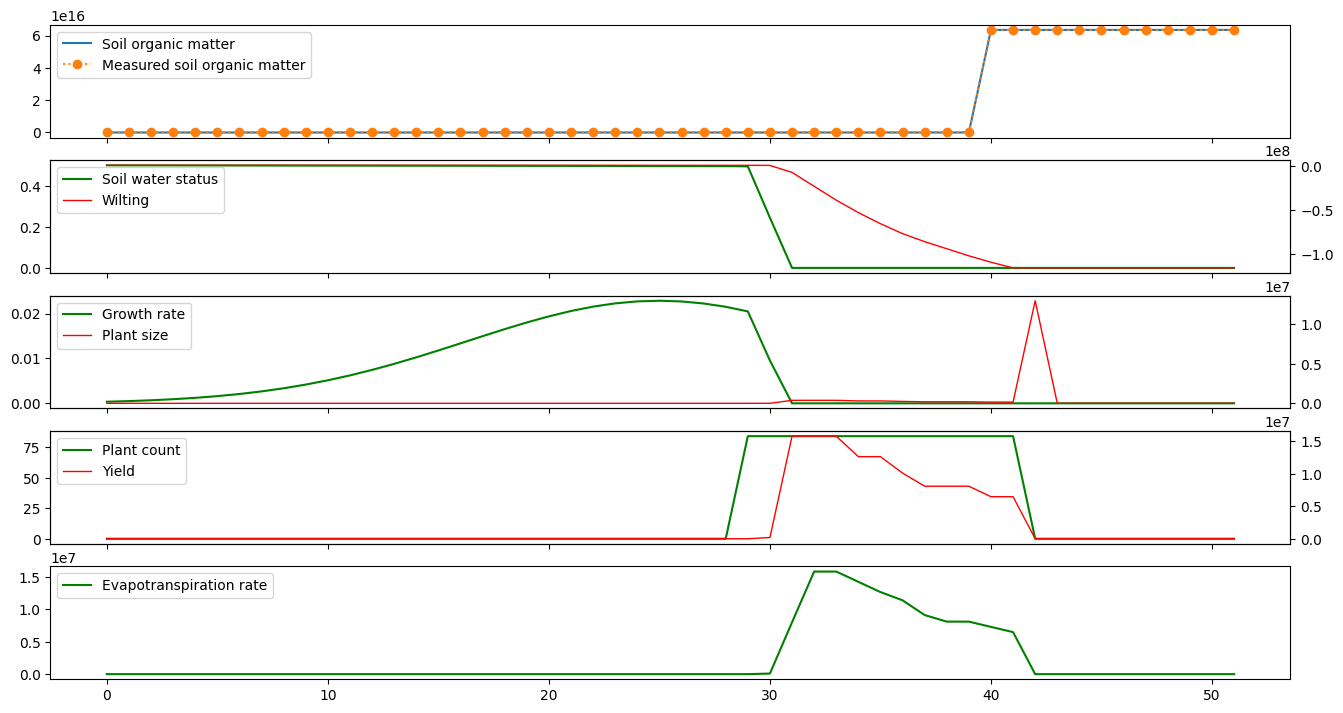

In [5]:
# Draw prior beliefs using the predictive samples
fig = draw_beliefs(
        prediction_samples,
        var_1={
            "soil_organic_matter": "Soil organic matter",
            "soil_water_status": "Soil water status",
            "growth_rate": "Growth rate",
            "plant_count": "Plant count",
            "evapotranspiration_rate": "Evapotranspiration rate"
        },
        var_2={
            "obs_soil_organic_matter": "Measured soil organic matter",
            "wilting": "Wilting",
            "plant_size": "Plant size",
            "obs_yield": "Yield",
            None: None
        },
        measured=[True, False, False, False, False],
        fig_size=(16, 8.5)
    )

## 2.4. Performing inference and visualising the results

### 2.4.1. Performing inference

First, let's provide the agent with the data it should use to perform inference.

In [6]:
# Provide the data to the deterministic agent
data = {
    'obs_soil_organic_matter': prediction_samples['obs_soil_organic_matter'][0]
}
cond_model, cond_guide = agent.condition_all(data=data)

 Second, let's create the mask specifying which observations are provided to the model:

In [7]:
# The measurement interval is the number of time steps between two observations made by the agent 
measurement_interval = 2

# Create the mask
mask = {
    'obs_soil_organic_matter': jnp.expand_dims(jnp.arange(len(data['obs_soil_organic_matter'])), -1) % measurement_interval == 0
}

Third, let's run inference using Monte Carlo Markov Chain (MCMC):

In [8]:
# Create the MCMC algorithm
mcmc_args = {
    "num_warmup": 1000,
    "num_samples": 1000, 
    "num_chains": 1
}
mcmc_algorithm = agent.inference_algorithm(MCMCKernel, kernel_args=mcmc_args)

# Perform inference using MCMC
inference_args = {
    "mask": mask,
    "data_level": 0
}
mcmc_samples = mcmc_algorithm.run_inference(inference_args=inference_args)

ValueError: Normal distribution got invalid scale parameter.

Fourth, let's run inference using Stochastic Variational Inference (SVI):

In [ ]:
# Create the SVI algorithm
svi_args = {
    "optimiser": optax_to_numpyro(optax.adabelief(1e-3, eps=1e-8, eps_root=1e-8)),
    "loss": Trace_ELBO(num_particles=10),
    "num_steps": 1000
}
svi_algorithm = agent.inference_algorithm(SVIKernel, kernel_args=svi_args)

# Perform inference using SVI
inference_params = {
    "stable_update": True, 
    "mask": mask,
    "data_level": 0
}
svi_samples = svi_algorithm.run_inference(inference_params=inference_params)

### 2.4.2. Visualising the posterior beliefs

Let's call the function in charge of comparing the initial predictions and the posterior distributions, i.e., MCMC and SVI posteriors:   

In [ ]:
# Compare the initial prediction, the SVI posterior, and the MCMC posterior
fig = compare_posteriors(
    is_observed=mask['lai'],
    mcmc_samples=mcmc_samples,
    svi_samples=svi_samples,
    prediction_samples=prediction_samples
)

## 3. Creating a custom agent

This section describes how to create a custom agent compatible with the Digital Gaia engine. An agent is composed of two main components, i.e., a generative model and a variational distribution. To keep the agent simple, we consider a model with only one parameter $\theta \in \mathbb{R}^+$ that represents the growth rate of hemp. The model contains only two hidden variables at each time step $\tau$, i.e., the hemp size $s_\tau \in \mathbb{R}^+$ and whether the hemp can grow $g_\tau \in \{0, 1\}$. Additionally, the only observed variable in the model is the yield denoted $y_\tau \in \mathbb{R}^+$. Finally, the agent can take two actions, i.e., planting is denoted $p_\tau \in \{0, 1\}$ and harvesting is denoted $h_\tau \in \{0, 1\}$.

Note, the agent is provided with measurement of the yield for time steps between the initial time step, i.e., $\tau = 0$, and the present time step, i.e., $\tau = T$. Additionally, given any random variable $x_\tau$, the set of all $x_\tau$ in the past and present is denoted $\tilde{x} = \{x_0, ..., x_T\}$. For example, $\tilde{y} = \{y_0, ..., y_T\}$ represents all the yield measurements collected up to now, $\tilde{s} = \{s_0, ..., s_T\}$ represents the hemp size at all time steps in the past and present, and $\tilde{h} = \{h_0, ..., h_T\}$ describes the time steps at which the hemp was harvested.

## 3.1. The generative model and variational distribution

Note that understanding this section fully is not required for creating custom agents. However, having an idea of what a generative model and a variational distribution is, will helpful when we start coding.

### 3.1.1. The generative model

Let's now focus on the definition of the generative model, which is a Partially Observable Markov Decision Process (POMDP). In this section, a POMDP is a 4-tuple denoted $\mathcal{P} = (\mathcal{O}, \mathcal{S}, \mathcal{A}, \mathcal{\Phi})$, where $\mathcal{O} = \tilde{y}$ are the measurements of the model, $\mathcal{S} = \tilde{s} \cup \tilde{g}$ are the states of the model, $\mathcal{A} = \tilde{p} \cup \tilde{h}$ are the actions of the model, and $\mathcal{\Phi} = \{\theta\}$ are the model paramters. Moreover, a POMDP restricts the flexibility of the model by imposing constraints on its structure.

For example, $\mathcal{P}$ assumes that the measurement at time step $\tau$ depends only on the states and actions at time step $\tau$, i.e., $P(y_\tau | s_\tau, h_\tau)$, while the states at time step $\tau + 1$ can depend on the states and actions at time step $\tau$ as well as on the parameters, i.e., $P(g_{\tau + 1} | g_\tau, h_\tau, p_\tau)$ and $P(s_{\tau + 1}| s_\tau, g_\tau, h_\tau, \theta)$. Lastly, the parameters and the initial states does not depend on any other random variables, i.e., $P(\theta)$, $P(g_0)$ and $P(s_0)$. Putting everything together, the generative model is defined as:

$$
P(\tilde{y}, \tilde{g}, \tilde{s}, \theta | \tilde{h}, \tilde{p}) \quad\quad = \underbrace{P(\theta)P(g_0)P(s_0)}_{\text{prior over initial states and parameter}} \quad \prod_{\tau = 0}^{T} \underbrace{P(y_\tau | s_\tau, h_\tau)}_{\text{likelihood mapping}} \quad \prod_{\tau = 0}^{T - 1} \underbrace{P(g_{\tau + 1} | g_\tau, h_\tau, p_\tau)P(s_{\tau + 1}| s_\tau, g_\tau, h_\tau, \theta)}_{\text{transition mapping}}.
$$

While the above equation defines the structure of the model, it does not define the exact probability distributions used for each factor. In this section, the uncertainty of about the hemp growth rate is modelled as a Gamma distribution, i.e., $P(\theta) = \text{Gamma}(\theta; 3, 0.06)$, whose concentration and rate parameters are equal to 3 and 0.06, respectively. Intuitively, since the mean of this Gamma distribution is around 50 millimeters, it means that the model believes that the hemp is growing by 5 centimeters every week.

Moreover, the uncertainty about the initial size of the hemp is modelled as a Gamma distribution, i.e., $P(s_0) = \text{Gamma}(s_0; 1, 0.1)$, whose concentration and rate parameters are equal to 1 and 0.1, respectively. This corresponds to an average height of 10 millimeters, and encodes the fact that initially there is no hemp present in the field, and the expected plant height is very close to zero. 

Clearly, one could model the uncertainty about whether the hemp can grow at time $\tau = 0$ using a Bernoulli distribution, i.e., $P(g_0) = \text{Bernoulli}(g_0; 0.05)$, where the hemp can grow with a probability of 0.05. However, using discrete random variables in Numpyro is challenging and can produce errors. Instead, we set $g_0$ equal to zero, i.e., the hemp cannot grow at time $\tau = 0$. More formally, this corresponds to a delta distribution over $g_0$, i.e.,

$$P(g_0) = \begin{cases}
1 & \text{if } g_0 = 0\\
0 & \text{otherwise}.
\end{cases}
$$

Now let's focus on the definition of the transition and likelihood mappings. The model assumes that the hemp size will remain the same if it cannot grow, i.e., $g_{\tau - 1} = 0$, otherwise the hemp will grow according to the growth rate $\theta$. For example, if $\theta$ is equal to 48, then the hemp will grow by 48 millimeters. Additionally, if the farmer harvested the field at time step $\tau$, the hemp size at time $\tau + 1$ will be zero. This behaviour can be expressed as follows:

$$P(s_{\tau + 1}| s_\tau, g_\tau, h_\tau, \theta) = \begin{cases}
1 & \text{if } s_{\tau + 1} = (s_\tau + \theta \times g_\tau) \times (1 - h_\tau)\\
0 & \text{otherwise} 
\end{cases}.$$

Next, the hemp can grow if it was able to grow at the previous time step, except if the farmer decided to harvest. Furthermore, the hemp can grow if it was not able to grow at the previous time step, but the farmer decided to plant some seed in the field. In other words:

$$P(g_{\tau + 1} | g_\tau, h_\tau, p_\tau) = \begin{cases}
1 & \text{if } g_{\tau + 1} = g_\tau \times (1 - h_\tau) + (1 - g_\tau) \times p_\tau\\
0 & \text{otherwise} 
\end{cases}.$$

Lastly, the yield is zero except when the farmer is harvesting the crop, in this case, it is equal to the hemp size just before the harvest. Formally, we have:

$$P(y_\tau| s_\tau, h_\tau) = \begin{cases}
1 & \text{if } y_\tau = s_\tau \times h_\tau\\
0 & \text{otherwise} 
\end{cases}.$$

### 3.1.2. The variational distribution

In the previous section, we defined the generative model $P(\mathcal{O}, \mathcal{S}, \mathcal{\Phi} | \mathcal{A})$. Given some measurements $\mathcal{O}$, we would like to update our beliefs about the states of the world. The process of updating our beliefs about the world to account for new data is called inference. More formally, the goal is to compute the posterior distribution, i.e.,

$$\underbrace{P(\mathcal{S}, \mathcal{\Phi} | \mathcal{O}, \mathcal{A})}_{\text{true posterior}} \propto \underbrace{P(\mathcal{O}, \mathcal{S}, \mathcal{\Phi} | \mathcal{A})}_{\text{generative model}}.$$

Unfortunatly, computing the posterior requires marginalising the generative model over the hidden variables of the model (i.e., $\mathcal{S}$, and $\mathcal{\Phi}$). When $\mathcal{S}$ is continuous then marginalising implies solving some integrals. In general, the marginalisation is intractable or too computationally expansive. Instead, we approximate the true posterior with a variational distribution:

$$\underbrace{Q(\mathcal{S}, \mathcal{\Phi} | \mathcal{A})}_{\text{variational posterior}} \,\approx \quad \underbrace{P(\mathcal{S}, \mathcal{\Phi} | \mathcal{O}, \mathcal{A})}_{\text{true posterior}}.$$

Then, we minimise the distance between the variational posterior and true posterior. The Kullback-Leibler divergence is a frequently used quantity that measures how different two distributions are. Thus, the optimisation problem is given by: 
$\newcommand{\kl}[2]{D_{\mathrm{KL}} \left[ \left. \left. #1 \right|\right| #2 \right]}$ $\DeclareMathOperator*{\argmin}{arg\,min}$

$$Q^*(\mathcal{S}, \mathcal{\Phi} | \mathcal{A}) = \argmin_{Q(\mathcal{S}, \mathcal{\Phi} | \mathcal{A})} \kl{Q(\mathcal{S}, \mathcal{\Phi} | \mathcal{A})}{P(\mathcal{S}, \mathcal{\Phi} | \mathcal{O}, \mathcal{A})}$$

Minimising the above Kullback-Leibler divergence is equivalent to minimising the variational free energy defined as follows:

$$\mathcal{F}\big[Q(\mathcal{S}, \mathcal{\Phi} | \mathcal{A}), \mathcal{O}, \mathcal{A}\big] = \underbrace{\kl{Q(\mathcal{S}, \mathcal{\Phi} | \mathcal{A})\,}{P(\mathcal{S}, \mathcal{\Phi} | \mathcal{A})}}_{\text{complexity}} - \underbrace{\mathbb{E}_{Q(\mathcal{S}, \mathcal{\Phi} | \mathcal{A})}\big[\ln P(\mathcal{O} | \mathcal{S}, \mathcal{\Phi})\big]}_{\text{accuracy}}$$

Intuitively, the variational free energy is composed of two terms. The accuracy describes how well the measurements are predicted by the likelihood mapping $P(\mathcal{O} | \mathcal{S}, \mathcal{\Phi})$, while the complexity quantifies how far the posterior $Q(\mathcal{S}, \mathcal{\Phi} | \mathcal{A})$ is from the prior $P(\mathcal{S}, \mathcal{\Phi} | \mathcal{A})$. Thus, the complexity can be see as a regularisation term that keeps the variational posterior as close as possible to the prior, while the accuracy pull the posterior away from the prior to achieve good predictions.

There are different ways to defines the variational posterior. One of them is to assume that the variational distribution is distributed according to a Gaussian distribution, i.e., $Q(\mathcal{S}, \mathcal{\Phi} | \mathcal{A}) = \mathcal{N}(\mathcal{S}, \mathcal{\Phi}; \boldsymbol{\mu}, \boldsymbol{\Sigma})$. Fortunatly, Numpyro provides an easy to use Gaussian posterior, and we use it in the following sections. Note, while variational inference is fast, it may not always be possible to use Numpyro's built-in variational distributions, also known as guides. For example, performing variational inference on models with both discrete and continuous variables is challenging. In this case, the user either needs to implement its own guide, or use another inference algorithm such as Monte Carlo Markov chain.

## 3.2. The agent interface

The agent interface is a class that all agents must implement to be compatible with the Digital Gaia engine. It represents the interface through which the agents communicate with the engine. In this section, we discuss the functions that custom agents need to implement, as well as the functionality provided by the interface.

### 3.2.1. Inheritance and custom functionalities

As mentionned, the agent interface is key to the creation of new agents. First, custom agents need to inherit from the interface, then, custom agents need to implement the abstract methods of the interface. There are three abstract methods that needs to be implemented by new agents, i.e., `model`, `guide`, and `add_reports`. The first two methods is where the code of the generative model and variational distribution goes, while the third one allows the agent to receive and integrate new reports. The `model` is defined as follows:

```python
@abc.abstractmethod
def model(self, *args, **kwargs):
    """
    Implement the generative model
    :param args: the model's arguments
    :param kwargs: the model's keyword arguments
    """ 
    ...
```
All models takes a list of arguments as well as a dictionary of keyword arguments as parameters. The keyword arguments are the arguments whose name are provided when calling the function. e.g., `agent.model(arg_1, arg_2, name_1=kwarg_1, name_2=kwarg_2)`. The `guide` is defined very similarly:
```python
@abc.abstractmethod
def guide(self, *args, **kwargs):
    """
    Implement the guide
    :param args: the guide's arguments
    :param kwargs: the guide's keyword arguments
    :return: the guide
    """ 
    ...
```
All guides takes a list of arguments as well as a dictionary of keyword arguments as parameters. Moreover, the guide function returns the agent's guide, i.e., generally a built-in Numpyro guide. Finally, `add_reports` is defined as follows:
```python
@abc.abstractmethod
def add_reports(self, reports):
    """
    Provide new reports to the model
    :param reports: the new reports
    """ 
    ...
```
This method takes a list of reports as parameter, then for each report, the method must extract the measurements it contains. Once the measurements have been extracted, a new report (i.e., a jax array) must be created and concatenated to the attribute called `reports`. Note, the `reports` attribute have the following shape: `[n_time_steps, n_lots, n_observations]`. The first dimension correspond to the number of time steps for which the agent has received a report, `n_lots` is the number of lots in the project, and `n_observations` is the number of measurements available for this project. 

### 3.2.2. Out-of-the-box functionalities

In the previous section, we described the functionalities that a developer needs to implement for an agent to be compatible with the Digital Gaia engine. However, the agent interface provides out-of-the-box features. For example, a common task is to perform prediction about the future based on the agent's model. The agent interface exposes a method called `predict` that uses Numpyro's `Predictive` class to do exactly that:
```python
def predict(self, **kwargs):
    """
    Perform prediction
    :param kwargs: keyword parameters to send to the "Predictive" class
    :return: the predictions
    """ 
    self.rng_key, rng_key_ = random.split(self.rng_key)
    predict = Predictive(**kwargs)
    return predict(rng_key)
```

Moreover, while by default the agent is performing the sequence of actions described in the project's configuration file, one may want to estimate the quality of a custom policy. The current policy can be retrieved using the following getter:
```python
@property
def policy(self):
    """
    Policy getter
    :return: the agent's policy
    """ 
    return self.agent_policy
```

In practice, this getter can be called like this: `current_policy = agent.policy`. Similarly, a custom policy can be set using the following setter: 
```python
@policy.setter
def policy(self, new_policy):
    """
    Policy setter
    :param new_policy: the new policy that the agent should follow
    """
    self.agent_policy = deepcopy(new_policy)
    self.set_time_horizon(self.agent_policy.shape[0])
```

In practice, this getter can be called like this: `agent.policy = custom_policy`. Also, when performing inference, it is required to provide the agent with some measurments. This can be done using `condition_model`, `condition_guide`, and `condition_all`. As the name suggests, `condition_model` provides the data to the agent's model. Technically, this is done by using Numpyro's conditioning handler as follows:
```python
def condition_model(self, data):
    """
    Condition the model on some data
    :param data: the data
    :return: the conditioned model
    """
    # Condition the model on the data
    self.conditioned_model = numpyro.handlers.condition(self.model, data=data)
    return self.conditioned_model
```

When performing variational inference, the data also needs to be provided to the variational distribution. This is achieved using the function `condition_guide` that provides the model conditioned on the data to the agent's guide:
```python
def condition_guide(self, model):
    """
    Condition the guide on some data
    :param model: the model conditioned on the data
    :return: the conditioned guide
    """
    # Ensure that the agent has implemented the variational distribution
    if self.guide is None:
        return None

    # Condition the variational distribution on the data
    self.conditioned_guide = partial(self.guide, model)
    return self.conditioned_guide
```

Additionally, it is a bit tedious to call both the `condition_model` and `condition_guide` functions each time we want to provide the data to both the model and the guide. The method `condition_all` solves this problem by calling both functions:
```python
def condition_all(self, data):
    """
    Condition the model and the guide on some data
    :param data: the data
    :return: the conditioned model and guide
    """ 
    self.condition_model(data)
    self.condition_guide(self.conditioned_model)
    return self.conditioned_model, self.conditioned_guide
```

After providing the data to the agent, we need to retrieve the inference algorithm and use it to compute the posterior beliefs. The agent interface has a method called `inference_algorithm` that returns the inference algorithm. By default, it creates a stochastic variational inference (SVI) kernel. However, any kernel can be provided as parameter, i.e.,
```python
def inference_algorithm(self, kernel=None, **kwargs):
    """
    Getter
    :param kernel: the kernel to use, by default the SVIKernel if a guide is found otherwise the MCMCKernel
    :param kwargs: additional parameters that must be passed to the kernel
    :return: the inference kernel to use
    """
    # Retrieve the most informed model
    model = self.model if self.conditioned_model is None else self.conditioned_model

    # If no kernel specified and no guide, create the MCMC inference algorithm
    if kernel is None and self.no_guide_implemented():
        return MCMCKernel(model=model, **kwargs)

    # If no kernel specified but a guide is available, create the SVI inference algorithm
    if kernel is None:
        return SVIKernel(model=model, guide=self.conditioned_guide, **kwargs)

    # Create the inference algorithm requested by the user
    return kernel(model=model, guide=self.conditioned_guide, **kwargs)
```

Once the kernel is retrieved using `kernel = agent.inference_algorithm()`, inference can be performed by calling the following kernel function:
```python
@abc.abstractmethod
def run_inference(self, *args, **kwargs):
    """ 
    Compute posterior beliefs
    :param args: the inference arguments
    :param kwargs: the inference keyword arguments
    :return: samples from the posterior distribution
    """
    ...
```

This above function computes the posterior beliefs, and returns samples from the associated posterior distribution. 

### 3.2.3. Advanced out-of-the-box functionalities

In the previous section, we described standard out-of-the-box functionalities provided by the agent interface. These functionalities are useful for someone wanting to use an agent to perform either prediction or inference. However, when actually implmenting a custom agent, a few other functions becomes of interest. These are report or ontology related functions. The first function is called `observations`, and returns the list of all the observation names the agent is modelling, i.e.,
```python
@property
def observations(self):
    """
    Observations getter
    :return: the names of all the observations supported by the agent
    """
    return self.obs_to_site.keys()
```

Note, `self.obs_to_site` is a dictionary that maps the observation names as found in the ontology to the sample site names used by the model. Similarly to the `observations` function, the function called `sample_sites` returns the list of all the sample site names used by the agent, i.e.,
```python
@property
def sample_sites(self):
    """
    Sample site getter
    :return: the name of the sample sites corresponding to the agent's observations
    """
    return self.obs_to_site.values()
```

Note, the sample site names are the names used when calling the Numpyro primitive `sample`, for example, `sample("sample_site_name", Normal(0, 1))`. Our third method is called `to_sample_site`, and returns the sample site name corresponding to the observation name passed as paramater:
```python
def to_sample_site(self, obs_name):
    """
    Getter
    :param obs_name: the observation name whose sample site should be returned
    :return: the name of the sample site associated with the observation name
    """
    return self.obs_to_site[obs_name]
```
The last report related function is named `get_report_by_sample_site`. This method returns a dictionary where the keys correspond to sample site names, and the values are the measurements of these sample sites, i.e.,
```python
def get_report_by_sample_site(self):
    """
    Gather the report data for each (numpyro) sample site
    :return: a python dictionary whose keys are sample site names and values are report data for these sites
    """
    return {
        self.to_sample_site(obs_name): jnp.expand_dims(self.reports[:, :, obs_id], axis=2)
        for obs_id, obs_name in enumerate(self.data.obs_names) if obs_name in self.observations
    }
```

Finally, as discussed below, recovering the ontology entry associated with a variable's value is very useful, and is done by calling `ontology_name`:
```python
@staticmethod
def ontology_name(variable_enum, variable_value):
    """
    The name of the variable described by the parameters, i.e., the name of the ontology entry
    :param variable_enum: the enumeration corresponding to the variable
    :param variable_value: the value taken by the enumeration
    :return: the name of the ontology entry
    """
    prefix = "natural_models.ontology."
    ontology_name = variable_enum.__module__ + "." + variable_enum.__name__ + "." + variable_value
    return ontology_name[len(prefix):]
```
The `ontology_name` function takes two parameters the first is the enumeration associated with the variable of interrest, e.g., `HarvestCrops`, and the second is a string containing the variable's value, e.g., `Hemp`. All the enumeration can be found in the `natural_models.ontology` package.

## 3.3. The code of the custom agent

In the previous section, we described the methods of the `AgentInterface`. Let's now focus on creating the code of a custom agent! First, we need to create a new file called `get_started_agent.py` that will contain our custom agent. This should be done in the folder called `<natural_models_repository>/src/natural_models/agents/impl/`, where `impl/` is for classes **impl**ementing the agent interface. First, let's import the required packages at the beginning of this file:

```python
from natural_models.ontology.v0.measurement.base.agriculture.Yield import HempYield
from natural_models.ontology.v0.vegetation.base.agriculture.Plant import PlantSpecies
from natural_models.ontology.v0.intervention.base.agriculture.Harvest import HarvestCrops as HarvestCrops
from natural_models.ontology.v0.intervention.base.agriculture.Planting import PlantingSeeds as PlantingSeeds
from jax.tree_util import tree_map
from natural_models.agents.AgentInterface import AgentInterface
import jax.numpy as jnp
from jax.numpy import stack, pad, array
import numpy as np
from numpyro import sample, deterministic, plate
from numpyro.contrib.control_flow import scan
from numpyro.distributions import Normal, Gamma
from numpyro.infer.autoguide import AutoMultivariateNormal
```

Then, we need to create a class named `GetStartedAgent` that inherits from the `AgentInterface`. Moreover, this class needs to have two class attributes, i.e., `species` and `actions`. The `species` attribute is a list of species that the model is compatible with, while the `actions` attribute is a list of actions (also known as interventions) that the model supports. In practice, this is done as follows:

```python
class GetStartedAgent(AgentInterface):
    """
    A class serving as an example of custom agent.
    """

    # The agent's species
    species = [
        AgentInterface.ontology_name(PlantSpecies, "Hemp")
    ]

    # The agent's actions
    actions = [
        AgentInterface.ontology_name(HarvestCrops, "Hemp"),
        AgentInterface.ontology_name(PlantingSeeds, "HempSeeds")
    ]
```

The next step is to tell python how to create instances of the `GetStartedAgent`. More formally, we need to implement the constructor of the class. The constructor first needs to call the parent constructor, i.e., the constructor of `AgentInterface`. The parent constructor takes three parameters: the agent name (i.e., `"Tutorial.GetStarted"`), the data loader (i.e., `data`), and the observation to sample site dictionary (i.e., `obs_to_site`). This dictionary maps the observation name(s) as found in the ontology, to the sample site name(s) used in the model. Lastly, the constructor stores information about lots and actions, then it formats the policies &ndash; using `to_array` &ndash; to fit the model needs:

```python
    def __init__(self, data):
        """
        Construct the get started agent
        :param data: an instance of the data loader containing information about lots and reports.
        """

        # Call the AgentInterface constructor
        obs_to_site = {
            AgentInterface.ontology_name(HempYield, "Continuous"): "obs_yield"
        }
        super().__init__("Tutorial.GetStarted", data, obs_to_site=obs_to_site)

        # Store actions information
        self.action_names = ["planting-hemp", "harvest-hemp"]
        self.n_actions = len(self.action_names)

        # Store lots information
        self.n_lots = len(self.data.lots)

        # Pre-process the default policies
        self.policy = stack([self.to_array(policy) for policy in data.policies], -2)
```

Note, the `to_array` function converts the list of action names, e.g., `[[], ["planting-hemp", "harvest-hemp"]]`, into the corresponding array of action indices, e.g., `[[0, 0], [1, 2]]`. In practice, this is done as follows:


```python
    def to_array(self, policy):
        """
        Convert the list of action names into the corresponding array of action indices
        :param policy: the list of action names
        :return: the array of action indices
        """

        # Replace action names by their corresponding indices
        policy = tree_map(lambda action: self.action_names.index(action) + 1 if action else action, policy)

        # Pad the actions to ensure they all have the same length
        return stack([pad(array(actions), (0, self.n_actions - len(actions))) for actions in policy])
```

Now that python knows how to create the `GetStartedAgent`, the only thing left is to implement the three abstract methods of the `AgentInterface`, i.e., `add_reports`, `model`, and `guide`. The `model` of the `GetStartedAgent` is based on the following two methods:

```python
    def is_performed(self, action, actions_performed):
        """
        Check whether an action is performed
        :param action: the action for which the check is done
        :param actions_performed: all the performed actions
        :return: True if the action is performed, False otherwise
        """
        return jnp.any(self.index_of(action) + 1 == actions_performed, -1)

    def index_of(self, action_name):
        """
        Getter
        :param action_name: the name of the action whose index must be returned
        :return: the action index
        """
        return self.action_names.index(action_name)
```

Importantly, the `model` implements the generative model presented in Section 3.1.1. using Numpyro primitives. Most of the code is well documented, so we only explain the role of these primitives. The `sample` primitive takes two paramters, i.e., the sample site name and its associated distribution. The role of `sample` is to create a sample site for the name provided as input, and draw a sample from the associated distribution. The `plate` primitive creates copies of all the sample sites created within its scope. It takes two parameters, the first is the plate's name and the second is the number of copies to create. Finally, the `scan` primitive is an efficient implementation of a for loop that takes three parameters. The first is the function to call within the for loop, the second are the initial carrying state (i.e., these can have an arbitrary shape), and the third are the values on which the scan is performed (i.e., these must share the same size for their leading axis). With that in mind the model is defined as follows:

```python
    def model(self, *args, time_horizon=-1, **kwargs):
        """
        The generative model of the agent
        :param args: unused positional arguments
        :param time_horizon: the number of time steps the model needs to be unrolled for
        :param kwargs: unused keyword arguments
        """

        # Make sure the time horizon is valid
        time_horizon = len(self.policy) if time_horizon == -1 else time_horizon

        # Ensure the model can be used with several lots, i.e., duplicate the model for each lot
        with plate('n_lots', self.n_lots):

            # Sample the initial hemp size and ensure that the hemp cannot grow initially
            hemp_size = sample("hemp_size_0", Gamma(1, 0.1).expand((1, 1)))
            hemp_can_grow = jnp.zeros_like(hemp_size)

            # Sample the hemp growth rate from a Gamma distribution
            hemp_grow_rate = sample("hemp_growth_rate", Gamma(3, 0.06))

        # Make sure all the inputs of the scan function have the same size
        time_indices = jnp.expand_dims(jnp.expand_dims(jnp.arange(0, time_horizon), axis=1), axis=2)
        time_indices = jnp.repeat(time_indices, self.n_lots, axis=1)
        policy = self.policy[:time_horizon]

        # Call the scan function that unroll the model over time
        scan(self.model_dynamic, (hemp_size, hemp_can_grow, hemp_grow_rate), (time_indices, policy))
```

However, the above `model` relies upon the method called `model_dynamic`, which contains the code describing the temporal dynamics of the model. Once again, the code of this method is self-explanatory and well documented (see below). However, note that, if a measurement is available for a sample site, then a pseudo-random number generator (PRNG) key needs to be passed to the corresponding `sample` primitive. This rules applies to all simple sites within the function called by `scan`, i.e., within the `model_dynamic` function. The agent interface provides such a key as an attribute, which can be access as follows: `self.rng_key`. The `model_dynamic` is implemented as follows:

```python
    def model_dynamic(self, states_t, values_t):
        """
        Implement the model dynamic
        :param states_t: the state of the lot at time t
        :param values_t: the current time step, the growth rate and the actions performed at time t
        :return: the states at time t + 1
        """

        # Unpack the states and values at time t
        hemp_size_t, hemp_can_grow_t, hemp_growth_rate = states_t
        t, actions_performed = values_t

        # Ensure the model can be used with several lots, i.e., duplicate the model for each lot
        with plate('n_lots', self.n_lots):

            # Check if planting and harvesting are performed at time step t
            plant = self.is_performed("planting-hemp", actions_performed)
            harvest = self.is_performed("harvest-hemp", actions_performed)

            # Compute the states at time t + 1
            hemp_size_t1 = (hemp_size_t + hemp_growth_rate * hemp_can_grow_t) * (1 - harvest)
            hemp_size_t1 = deterministic(f"hemp_size", hemp_size_t1)
            hemp_can_grow_t1 = hemp_can_grow_t * (1 - harvest) + (1 - hemp_can_grow_t) * plant
            hemp_can_grow_t1 = deterministic(f"hemp_can_grow", hemp_can_grow_t1)

            # Compute the yield at time t
            sample("obs_yield", Normal(hemp_size_t * harvest, 0.1), rng_key=self.rng_key)

        return (hemp_size_t1, hemp_can_grow_t1, hemp_growth_rate), None
```

Next, we have the `guide` function implementing the variational distribution of the agent. In our case, it simply creates the Numpyro `AutoMultivariateNormal` guide, and returns it:

```python
    def guide(self, model, *args, **kwargs):
        """
        The variational distribution of the agent
        :param model: the model to provide to the guide
        :param args: unused positional arguments
        :param kwargs: unused positional keyword arguments
        :return: the guide
        """
        return AutoMultivariateNormal(model)
```

Finally, the last abstract method extracts the measurements from the reports provided as parameter:

```python
    def add_reports(self, reports):
        """
        Provide new reports to the model
        :param reports: the new reports
        """

        # Extract reports content as numpy array
        np_reports = stack([self.extract_measurements(reports, lot) for lot in range(self.n_lots)])
        np_reports = jnp.expand_dims(np_reports, axis=0)

        # Merge new report to already existing reports
        self.reports = jnp.concatenate((self.reports, np_reports), axis=0) if self.reports else np_reports
```

As shown above, `add_reports` simply calls `extract_measurements` for each lot, and stacks the results to create a numpy array containig the new reports. This numpy array is then concatenated with past reports. The implementation of `extract_measurements` goes as follows:

```python
    def extract_measurements(self, reports, lot_id):
        """
        Extract the measurements associated with a lot
        :param reports: the reports available
        :param lot_id: the lot's index whose measurements need to be retrieved
        :return: the lot's measurements
        """

        # Select only the measurements correspond to i-th lot
        reports = reports[reports['lot'] == lot_id]

        # Create the numpy array that will contain the measurements
        observations = np.zeros(self.number_of_measurements(reports))

        # Iterate over the observation names
        obs_id = 0
        for obs_name in self.observations:

            # Iterate over the measurements associated with these observations
            for measurements in reports[obs_name]:

                # Extract the measurements
                measurements = [measurements] if isinstance(measurements, float) else measurements
                for measurement in measurements:
                    observations[obs_id] = measurement
                    obs_id += 1

        return observations
```

Put simply, the function `extract_measurements` collects the measurements for all the sample sites that corresponds to the model's observations. This function relies on the method called `number_of_measurements` that counts the number of measurements present in the reports passed as parameter. This is carried out as follows:


```python
    def number_of_measurements(self, reports):
        """
        Getter
        :param reports: the reports
        :return: the number of measurements in the reports
        """

        # Get the measurements in the first row of the reports
        measurements = reports[self.observations].iloc[0].tolist()

        # Iterate over the measurements
        n_reports = 0
        for measurement in measurements:

            # Process each measurement
            if isinstance(measurement, float):
                n_reports += 1
            elif isinstance(measurement, list):
                n_reports += len(measurement)

        # Divide the total number of measurement by the number of lots
        return int(n_reports)
```

Our custom agent is now complete, the next section shows how to perform prediction and inference using this agent.

## 3.4. Visualising the custom agent

First, let's load the data and the custom agent:

In [ ]:
# Load the data corresponding to the GetStarted agent
data_loader = DataLoader(f'{fangorn_dir}/data/projects/Tutorial/GetStarted.json')
print(f'{fangorn_dir}/data/projects/Tutorial/GetStarted.json')

# Load the agent(s) compatible with the loaded data, and retrieve the GetStarted agent
agents = AgentFactory.create(data_loader, verbose=True)
agent = next(filter(lambda a: a.name == "Tutorial.GetStarted", agents))

Second, let's perform predictions about the future:

In [ ]:
# Predict the future using the GetStarted agent
prediction_samples = agent.predict(model=agent.model, num_samples=1)

Third, we visualise the results, and this time, we need to specify the variables to display in each subfigure. Each subfigure contains two variables, and the second variable may be a measurement of the first variable. The function `draw_beliefs` takes five parameters:
- `samples` are the samples used to draw each subfigure
- `var_1` is a dictionary whose keys are the sample sites' names for the first variable of each subfigure, and the values are the labels (in the legend) for the first variable of each subfigure
- `var_2` is a dictionary whose keys are the sample sites' names for the second variable of each subfigure, and the values are the labels (in the legend) for the second variable of each subfigure
- `measured` must be `True` if the second variable is a measurement of the first variable, and `False` otherwise
- `fig_size` the size of each subfigure

With this in mind, displaying the agent's prediction goes as follows:

In [ ]:
# Visualise the predictions
fig = draw_beliefs(
    prediction_samples,
    var_1={
        "hemp_size": "Hemp size",
        "hemp_can_grow": "Hemp can grow",
    },
    var_2={
        "hemp_growth_rate": "Hemp growth rate",
        "obs_yield": "Yield",
    },
    measured=[False, False],
    fig_size=(16, 4.5)
)

Fourth, let's provide the data to the agent:

In [ ]:
# Condition the agent on the data
data = {
    'obs_yield': prediction_samples['obs_yield'][0]
}
cond_model, cond_guide = agent.condition_all(data=data)

Fifth, let's run inference using Monte Carlo Markov Chain (MCMC):

In [ ]:
# Create the MCMC algorithm
mcmc_args = {
    "num_warmup": 10000,
    "num_samples": 10000, 
    "num_chains": 1
}
mcmc_algorithm = agent.inference_algorithm(MCMCKernel, kernel_args=mcmc_args)

# Perform inference using MCMC
mcmc_samples = mcmc_algorithm.run_inference()

Sixth, let's run inference using Stochastic Variational Inference (SVI):

In [ ]:
# Create the SVI algorithm
svi_args = {
    "optimiser": optax_to_numpyro(optax.adabelief(1e-3, eps=1e-8, eps_root=1e-8)),
    "loss": Trace_ELBO(num_particles=10),
    "num_steps": 1000
}
svi_algorithm = agent.inference_algorithm(SVIKernel, kernel_args=svi_args)

# Perform inference using SVI
inference_params = {
    "stable_update": True
}
svi_samples = svi_algorithm.run_inference(inference_params=inference_params)

Finally, we visualise the results, and this time, we need to specify the variables to display in each subfigure. Each subfigure contains two variables, and the second variable may be a measurement of the first variable. The function `compare_posteriors` takes five parameters:
- `mcmc_samples` are the samples from the MCMC posterior
- `svi_samples` are the samples from the SVI posterior
- `prediction_samples` are the samples from the inital agent's predictions
- `var_names` is the list of the sample site's names that need to be displayed, each one will have its own subfigure
- `var_labels` is the list of sample site's labels that need to be displayed along the y-axis
- `fig_size` the size of each subfigure

With this in mind, comparing the initial predictions to the MCMC and SVI posteriors goes as follows:  

In [ ]:
# Compare the initial prediction, the SVI posterior, and the MCMC posterior
fig = compare_posteriors(
    mcmc_samples=mcmc_samples,
    svi_samples=svi_samples,
    prediction_samples=prediction_samples,
    var_names=['hemp_size', 'hemp_can_grow'],
    var_labels=['Hemp size', 'Hemp can grow'],
    fig_size=(16, 4.5)
)

Congratulation, you can now contribute to the open science network! 🥳